### Packages

In [1]:
from pathlib import Path
from pydicom import dcmread
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
from scipy.interpolate import splrep, splev
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d, RegularGridInterpolator
import scipy.optimize as optimize
plt.rcParams['image.cmap'] = 'gray'

### Preprocessed data

In [2]:
cardio_path = Path().resolve().parents[1] / "dane" / "KARDIO ZAMKNIETE"
data_path = cardio_path / "A001" / "DICOM" / "P1" / "E1" / "S1"

Multidimensional array for one series of images

In [3]:
def convert_sequence_to_array(path: Path):
    return np.stack([np.flip(dcmread(file).pixel_array) for file in data_path.iterdir()], axis=0)

In [4]:
stacked = convert_sequence_to_array(data_path)

### Stakced image

In [5]:
path = Path().resolve().parents[1] / "dane" / "KARDIO ZAMKNIETE" / "A001" / "DICOM" / "P1" / "E1" / "S1"

In [6]:
def get_data(data_path: Path, skip_index: np.ndarray = np.concatenate((np.arange(61, 67), np.arange(68, 78),
                                                                       np.arange(79, 89), np.arange(90, 100),
                                                                       np.arange(101, 111), np.arange(113, 123),
                                                                       np.arange(124, 132)), axis=0)) -> np.ndarray:
    """
    Return array with CT image data

    Parameters
    ----------
    skip_index
    data_path : Path
        Path to folder with data

    Returns
    -------
    `np.ndarray`

    """
    return np.stack(
        [np.flip(dcmread(file).pixel_array) for idx, file in enumerate(data_path.iterdir()) if idx not in skip_index],
        axis=0)

### Image info

In [7]:
path_to_first_file = next(data_path.glob("*"))
dcm_file = dcmread(path_to_first_file)
print(f"Number of images: {stacked.shape[0]}")
print(f"Size of image: {stacked.shape[1]}x{stacked.shape[2]}")
print(f"Pixel size: {dcm_file.PixelSpacing} mm")
print(f"Reconstruction center: {dcm_file[(0x7005, 0x1007)].value}")
pixel_size_x = dcm_file.PixelSpacing[1]
pixel_size_y = dcm_file.PixelSpacing[0]
pixel_size = dcm_file.PixelSpacing[1]
print(pixel_size_x)

Number of images: 512
Size of image: 512x512
Pixel size: [0.402, 0.402] mm
Reconstruction center: [308, 216]
0.402


In [10]:
dcm_file

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 186
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.392.200036.9116.2.2047728388.1656374025.777523.1.328
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.840.113619.6.263
(0002, 0013) Implementation Version Name         SH: 'NUEVO_1_0'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.392.200036.9116.2.2047728388.1656374025.777523.1.328
(0008, 0020) Study Date                          DA: '20220627'
(0008, 0021) Series Date                         D

In [8]:
dcm_file.PixelSpacing

[0.402, 0.402]

### Hounsfield scale

The pixel values of this CT scan are expressed in Hounsfield Units:
$$
HU(x,y) = 1000 \cdot \frac{\mu{(x,y)} - \mu_{water}}{\mu_{water}-\mu_{air}}
$$
where $\mu$ is the attenuation coefficient of the material. The linear attenuation coefficient is defined based on how the intensity of a photon beam decays as it passes a distance $x$ through a material $I=I_{0}e^{-\mu x}$. Note that $\mu$ depends on the energy of the photon beam, and in a CT scan photons usually have energies 100 keV.

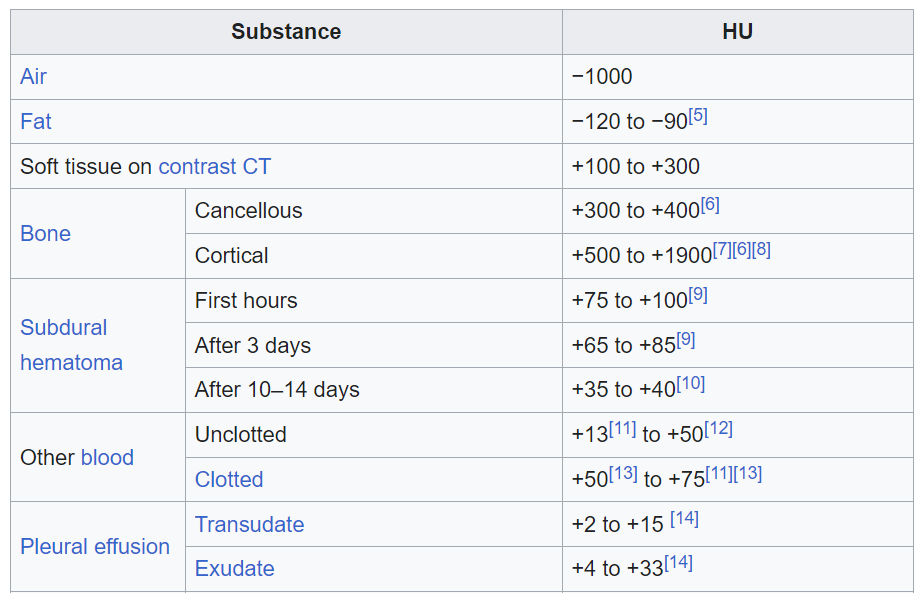

### Histogram of Hounsfield values

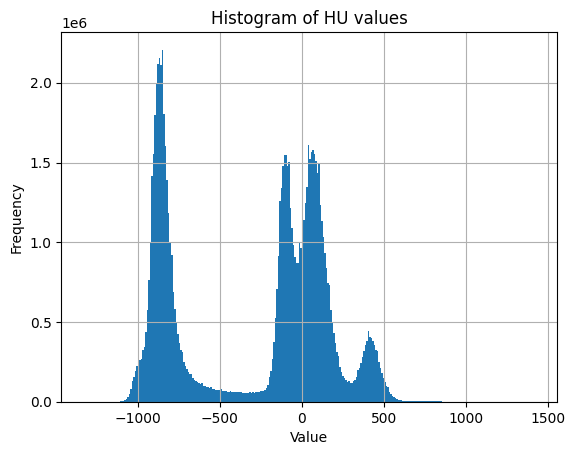

In [9]:
flattened_stacked = stacked.flatten()
flattened_filtered_stacked = flattened_stacked[flattened_stacked > -2000]
hist, bins = np.histogram(flattened_filtered_stacked, bins=300)
plt.hist(flattened_filtered_stacked, bins=300)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of HU values')
plt.grid()
plt.show()

### Noise assesment in CT
Basic concept of signal and noise:
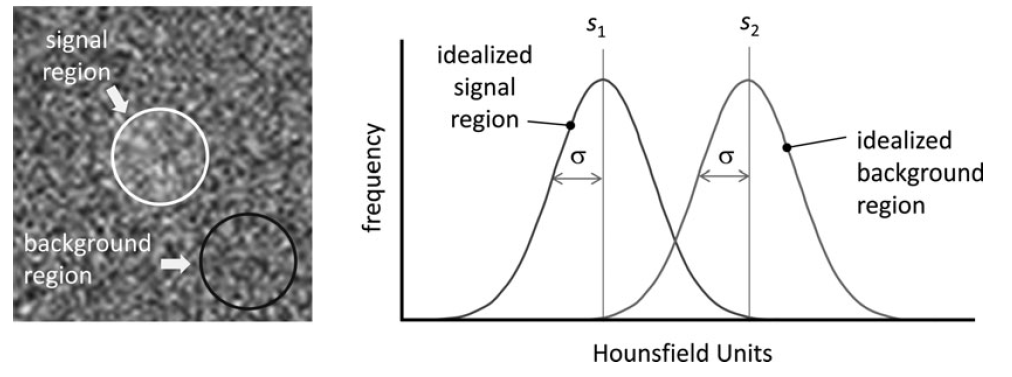
The noise distributions within the object and in the background are characterized by normal distributions defined by their standard deviations $\sigma$, with the shift between the two distributions corresponding to the signal amplitude: $|s_{1}-s_{2}|$. Although the signal-to-noise ratio is an important parameter in determining the detectability of an object, the SNR does not completely characterize noise. These two images with exactly the same noise level as measured by the standard
deviation $\sigma$ however, these two images have dramatically different appearances to the observer.
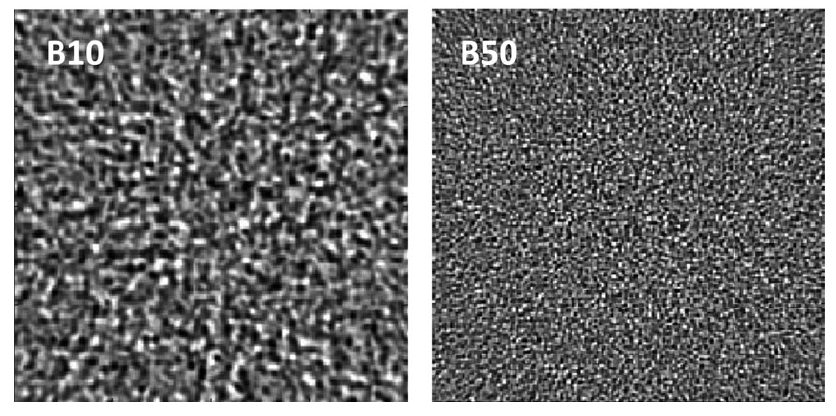
The differences between images are due to the noise texture, that is, the spatial-frequency distribution of the noise is different in these two images.  

**Noise power spectrum**  
The noise-power spectrum (NPS) is a useful measure that provides a more complete description of noise than the simple standard deviation. It describes the noise variance as a function of spatial frequency and therefore characterizes noise texture.  
**The NPS computation in CT scans** 
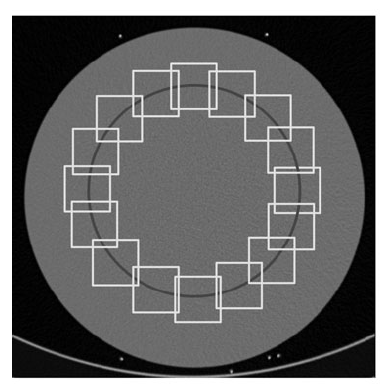
Select ROI (Region-of-Interest) sampled at a constant radius around the center of the phantom image. NPS can be calculated with the formula:
$$
NPS(f_{x},f_{y})=\frac{1}{N}\frac{\Delta_{x}\Delta_{y}}{N_{x}N_{y}}\sum_{i=1}^{N}|DFT_{2D}[I_{i}(x,y)-\bar{I_{i}}]|^{2}
$$
where:  
$N$ - the number of ROIs  
$I_{i}(x,y)$ - the signal in the $i^{th}$ ROI  
$\bar{I}$ - mean of $I_{i}(x,y)$  
$\Delta_{x}, \Delta_{y}$ - pixel size  
Result of NPS in spatial frequency $f_{x}, f_{y}$
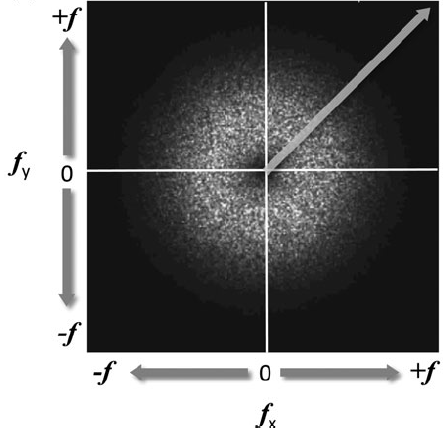  
Sigma $\sigma$ can be calculated with the formula:
$$
\sigma^{2} = \iint NPS_{2D}(f_{x}, f_{y}) df_{x}df_{y}
$$
**1D NPS**  
The $f_{x}$ and $f_{y}$ frequencies in the 2D NPS can be collapsed to a 1D radial frequency, $f_{r}$ by radially averaging using:  
$$
f_{r} = \sqrt{f_{x}^{2}+f_{y}^2}
$$
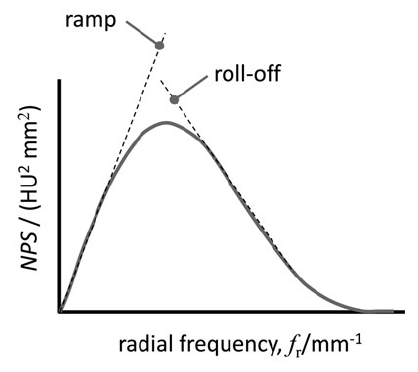
The initial positive slope of this curve results from the ramp filtering that is used in filtered-back-projection reconstruction, and the negative slope at higher spatial frequencies occurs due to the roll-off properties of the reconstruction kernel used to dampen high-frequency noise in the images.

### Input image

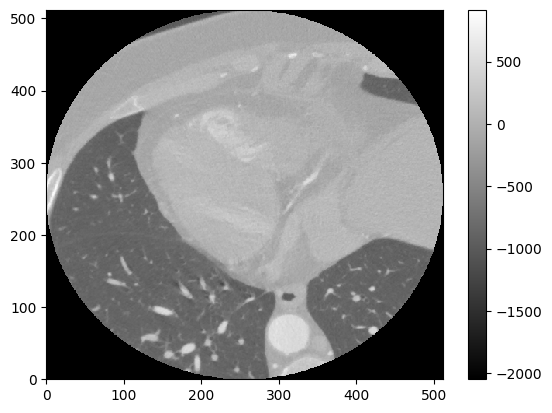

In [10]:
image = stacked[200]
plt.pcolormesh(image)
plt.colorbar();

### Utils method: 
- make plot

In [11]:
def make_plot(x_points, y_points, title, legend, min_x=0, max_x =1.0, num=64):
    x_interpolate = np.linspace(min_x , max_x, num)
    cubic_spline = CubicSpline(x_points, y_points)
    plt.plot(x_points, y_points,'.')
    plt.plot(x_interpolate, cubic_spline(x_interpolate),color='blue',label=legend)
    plt.title(title)
    plt.legend()
    plt.xlabel("$f_{r} [mm^{-1}]$")
    plt.xlim(min_x, max_x);
    plt.grid(which="minor", alpha=0.3)
    plt.grid(which="major", alpha=0.7)

In [12]:
def make_two_plots(x_points_1, y_points_1, x_points_2, y_points_2, title, legend_1, legend_2, min_x=0, max_x=1.0, num=64):
    x_interpolate = np.linspace(min_x , max_x, num)
    cubic_spline_1 = CubicSpline(x_points_1, y_points_1)
    cubic_spline_2 = CubicSpline(x_points_2, y_points_2)
    plt.plot(x_points_1, y_points_1, '.')
    plt.plot(x_points_2, y_points_2, '.')
    plt.plot(x_interpolate,cubic_spline_1(x_interpolate), label=legend_1)
    plt.plot(x_interpolate,cubic_spline_2(x_interpolate), label=legend_2)
    plt.legend()
    plt.title(title)
    plt.xlabel("$f_{r} [mm^{-1}]$")
    plt.xlim(min_x, max_x)
    plt.grid(which="major", alpha=0.7)

### ROIs

In [13]:
def select_ROI_array(image, y0, x0, size, num, plot=False):
    r = np.sqrt((y0-256)**2+(x0-256)**2)
    ROI_array = []
    if plot:
        plt.pcolormesh(image)
        plt.colorbar();
        plt.title("Selected ROIs")
    for i in range(num):
        y = int(r*np.cos((i*2*np.pi)/num)) + 256
        x = int(r*np.sin((i*2*np.pi)/num)) + 256
        if plot:
            plt.gca().add_patch(Rectangle((x-size//2,y-size//2),size,size,
                        edgecolor='red',
                        facecolor='none',
                        lw=1))
        ROI_array.append(image[y-size//2:y+size//2,x-size//2:x+size//2])
    return ROI_array

In [14]:
def select_ROI_array_ractangle(image, y0, x0, size, num, plot=False):
    r = np.sqrt((y0-256)**2+(x0-256)**2)
    ROI_array = []
    if plot:
        plt.pcolormesh(image)
        plt.colorbar();
        plt.title("Selected ROIs")
    for i in range(num):
        y = y0 + size*(i%3)
        if(i%3==0):
            x = x0 + size*(i//3)
        if plot:
            plt.gca().add_patch(Rectangle((x-size//2,y-size//2),size,size,
                        edgecolor='red',
                        facecolor='none',
                        lw=1))
        ROI_array.append(image[y-size//2:y+size//2,x-size//2:x+size//2])
    return ROI_array

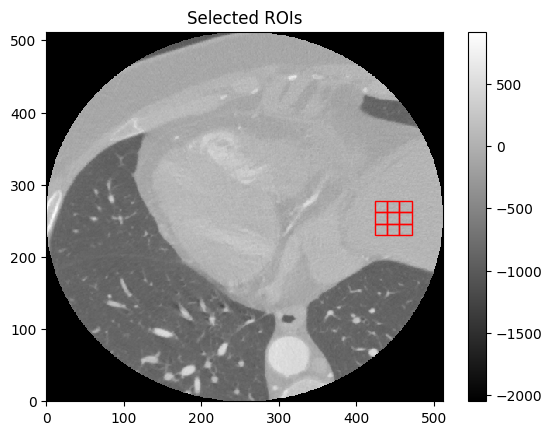

In [15]:
ROI_array_rectangle =select_ROI_array_ractangle(image=image, y0=238, x0=432, size=16, num=9, plot=True)

### NPS 2D

In [16]:
def calculate_NPS_2D(ROI_array, pixel_size_x, pixel_size_y):
    NPS_array = []
    for roi in ROI_array:
        rows, cols = roi.shape
        x = np.arange(cols)
        y = np.arange(rows)
        x, y = np.meshgrid(x, y)
        z = np.polyfit(x.ravel(), y.ravel(), 2)
        poly_fit = np.polyval(z, x)
        # Subtract the polynomial fit from the image
        roi = roi - poly_fit
        # calculation od DFT 2D
        dft = np.fft.fft2(roi - np.mean(roi))
        # shift of FT
        shifted_dft = np.fft.fftshift(dft)
        # calcation of absolute value
        NPS_array.append(np.abs(shifted_dft)**2)
    N = len(NPS_array)
    Ly = NPS_array[0].shape[0]
    Lx = NPS_array[0].shape[1]
    return (1/N)*(1/(Lx*Ly))*(np.sum(NPS_array,axis=0)*pixel_size_x*pixel_size_y)

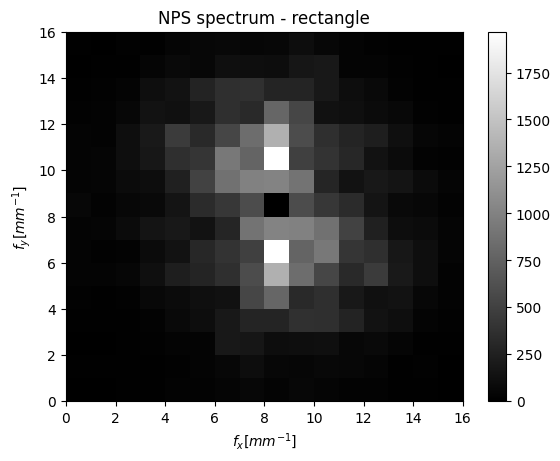

In [17]:
NPS_2D_rectangle = calculate_NPS_2D(ROI_array_rectangle, pixel_size_x, pixel_size_y)
plt.pcolormesh(NPS_2D_rectangle)
plt.title("NPS spectrum - rectangle")
plt.xlabel("$f_{x} [mm^{-1}]$")
plt.ylabel("$f_{y} [mm^{-1}]$")
plt.colorbar();

### NPS 1D

In [18]:
def calculate_NPS_1D_test(NPS_2D, size_of_pixel_in_spatial_domain):
    cen_x = NPS_2D.shape[1]//2
    cen_y = NPS_2D.shape[1]//2

    # Find radial distances 
    [X, Y] = np.meshgrid(np.arange(NPS_2D.shape[1])-cen_x, np.arange(NPS_2D.shape[1])-cen_y)
    R = np.sqrt(np.square(X)+np.square(Y))

    rad = np.arange(0, np.max(R), 1)
    intensity = np.zeros(len(rad))
    index = 0
    bin_size = 1

    for i in rad:
        mask = (np.greater(R, i - bin_size) & np.less(R, i + bin_size))
        rad_values = NPS_2D[mask]
        intensity[index] = np.mean(rad_values)
        index += 1
        # Plot data
    x = rad* 1.0 / (size_of_pixel_in_spatial_domain* NPS_2D.shape[1])
    y = intensity
    return x, y


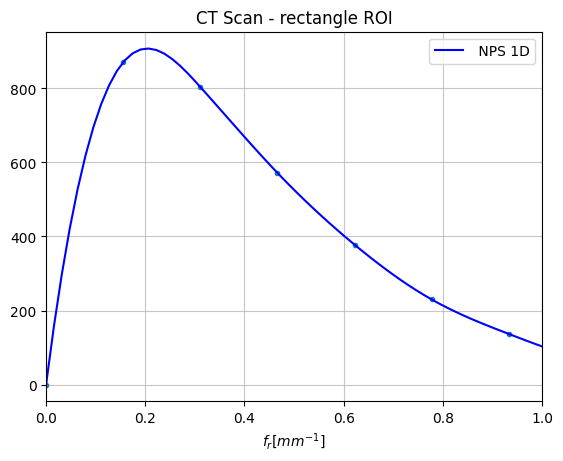

In [19]:
radius, intensity = calculate_NPS_1D_test(NPS_2D_rectangle, pixel_size)
make_plot(radius, intensity, title="CT Scan - rectangle ROI", legend = " NPS 1D", min_x=0, max_x =1.0, num=64)

### Sigma  
Sigma $\sigma$ can be calculated with the formula:
$$
\sigma^{2} = \iint NPS_{2D}(f_{x}, f_{y}) df_{x}df_{y}
$$

In [20]:
def calculate_sigma(image, pixel_size):
    ROI_array = select_ROI_array_ractangle(image=image, y0=238, x0=432, size=16, num=9)
    NPS = calculate_NPS_2D(ROI_array, pixel_size, pixel_size)
    dx = 1
    dy = 1
    return np.sqrt(np.trapz(np.trapz(NPS, dx=dx, axis=1), dx=dy, axis=0))

In [21]:
sigma = calculate_sigma(image, pixel_size)
print(f"Sigma: {sigma:.5}")

Sigma: 227.64


### Example of noise assesment using NPS after gaussian filter

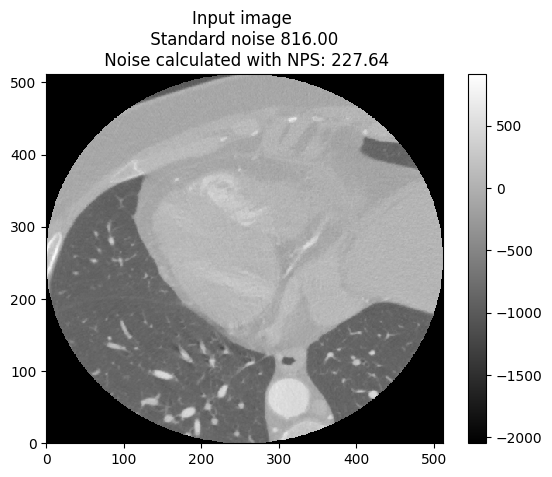

In [22]:
plt.pcolormesh(image)
plt.title(f"Input image \n Standard noise {np.std(image):.2f} \n Noise calculated with NPS: {calculate_sigma(image, pixel_size):.2f}")
plt.colorbar();

### Blurred image with gaussian filter

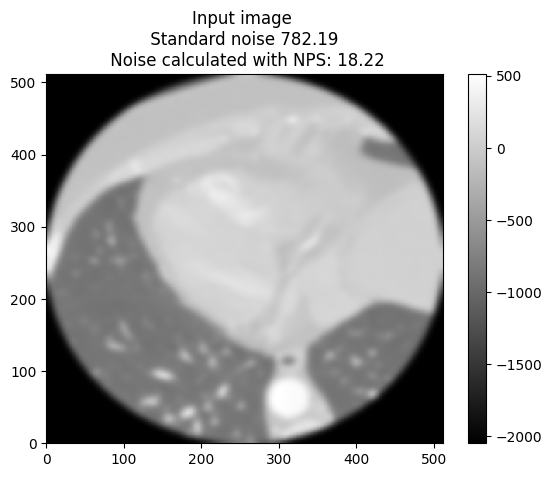

In [23]:
sigma = 4.5
filtered_image = gaussian_filter(image, sigma)
plt.pcolormesh(filtered_image)
plt.title(f"Input image \n Standard noise {np.std(filtered_image):.2f} \n Noise calculated with NPS: {calculate_sigma(filtered_image, pixel_size):.2f}")
plt.colorbar();

### NPS of blurred image

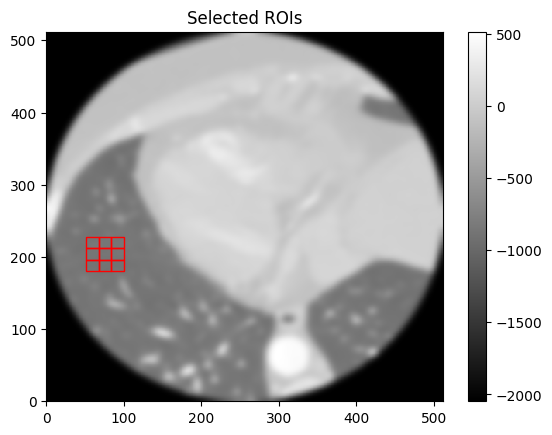

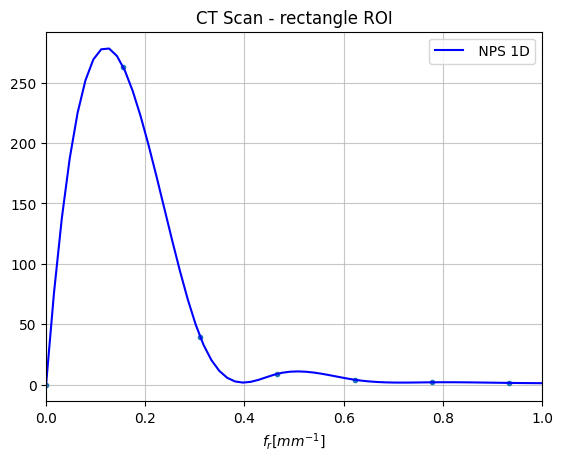

In [24]:
filtered_image = gaussian_filter(image, sigma)
ROI_array_rectangle =select_ROI_array_ractangle(image=filtered_image,y0=188, x0=60, size=16, num=9, plot=True)
plt.show()
NPS_2D_rectangle = calculate_NPS_2D(ROI_array_rectangle, pixel_size_x, pixel_size_y)
radius, intensity = calculate_NPS_1D_test(NPS_2D_rectangle,pixel_size_x)
make_plot(radius, intensity, title="CT Scan - rectangle ROI", legend = " NPS 1D", min_x=0, max_x =1.0, num=64)

### NPS of input image

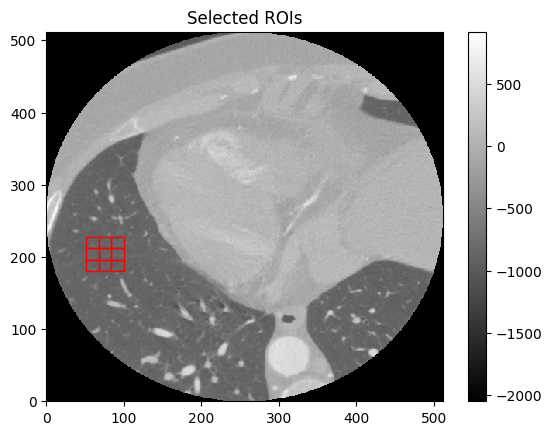

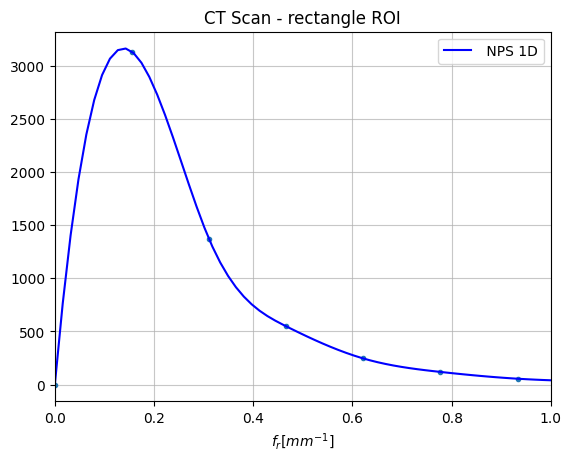

In [25]:
ROI_array_rectangle =select_ROI_array_ractangle(image=image, y0=188, x0=60, size=16, num=9, plot=True)
plt.show()
NPS_2D_rectangle = calculate_NPS_2D(ROI_array_rectangle, pixel_size_x, pixel_size_y)
radius, intensity = calculate_NPS_1D_test(NPS_2D_rectangle,pixel_size_x)
make_plot(radius, intensity, title="CT Scan - rectangle ROI", legend = " NPS 1D", min_x=0, max_x =1.0, num=64)

### External link
- https://vciba.springeropen.com/articles/10.1186/s42492-021-00087-9
- https://www.sciencedirect.com/science/article/pii/S1120179715003294
- https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0271724
- https://journals.sagepub.com/doi/abs/10.1093/jicru_ndt002

# Convolutional Neural Networks (CNNs) for Image Denoising

### Deep Image Prior  
Deep Image Prior is deep learning technique where neural network is used to reconstruct and image from noisy or incomplete data. Neural network is trained to generate high-quality images, without training on dataset. This technique is used to denoised images.  
- https://dmitryulyanov.github.io/deep_image_prior

In [26]:
import torch, torch.nn as nn
from IPython.display import display, clear_output

### Utils method: 
- converts torch array to numpy and vice-versa

In [27]:
def np_to_torch(np_array):
    return torch.from_numpy(np_array).float()

def torch_to_np(torch_array):
    return np.squeeze(torch_array.detach().cpu().numpy())

def save_array(np_array, file_name):
    with open(Path("output") /file_name, 'wb') as f:
        np.save(f, np_array)

def load_array(file_name):
    return np.load(Path('output') / file_name)

### NRMSE - Normalized Root Mean Squared Error  
$$NRMSE=\frac{\sqrt{\frac{1}{N}\sum{(Y_{i}-X_{i})^2}}}{\sqrt{\frac{1}{N}\sum{X_{i}^{2}}}} \cdot 100\%$$  
NRMSE is used as loss function it measueres "error" between reference and reconstructed image

In [28]:
def nrmse(recon, reference):
    n = (reference-recon)**2
    den = reference**2
    return 100.0*torch.mean(n)**0.5/torch.mean(den)**0.5

### CNN architecture - Deep Image prior

In [29]:
class CNN_configurable(nn.Module):
    def __init__(self, n_layers, n_channels, k_size):
        super(CNN_configurable, self).__init__()
        pd = int(k_size/2)
        layers = [nn.Conv2d(1,n_channels,k_size,padding=pd), nn.PReLU()]
        for _ in range(n_layers):
            layers.append(nn.Conv2d(n_channels, n_channels,  k_size, padding=pd)); layers.append(nn.PReLU())
        layers.append(nn.Conv2d(n_channels,1, k_size, padding=pd)); layers.append(nn.PReLU())
        
        self.deep_net = nn.Sequential(*layers)
    def forward(self,x):
        return torch.squeeze(self.deep_net(x.unsqueeze(0).unsqueeze(0)))

In [30]:
cnn = CNN_configurable(16,100,3)

In [31]:
cnn

CNN_configurable(
  (deep_net): Sequential(
    (0): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): PReLU(num_parameters=1)
    (4): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): PReLU(num_parameters=1)
    (6): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): PReLU(num_parameters=1)
    (8): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): PReLU(num_parameters=1)
    (10): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): PReLU(num_parameters=1)
    (12): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): PReLU(num_parameters=1)
    (14): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): PReLU(num_parameters=1)
    (16): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1

### ROI  
Selected region of interest

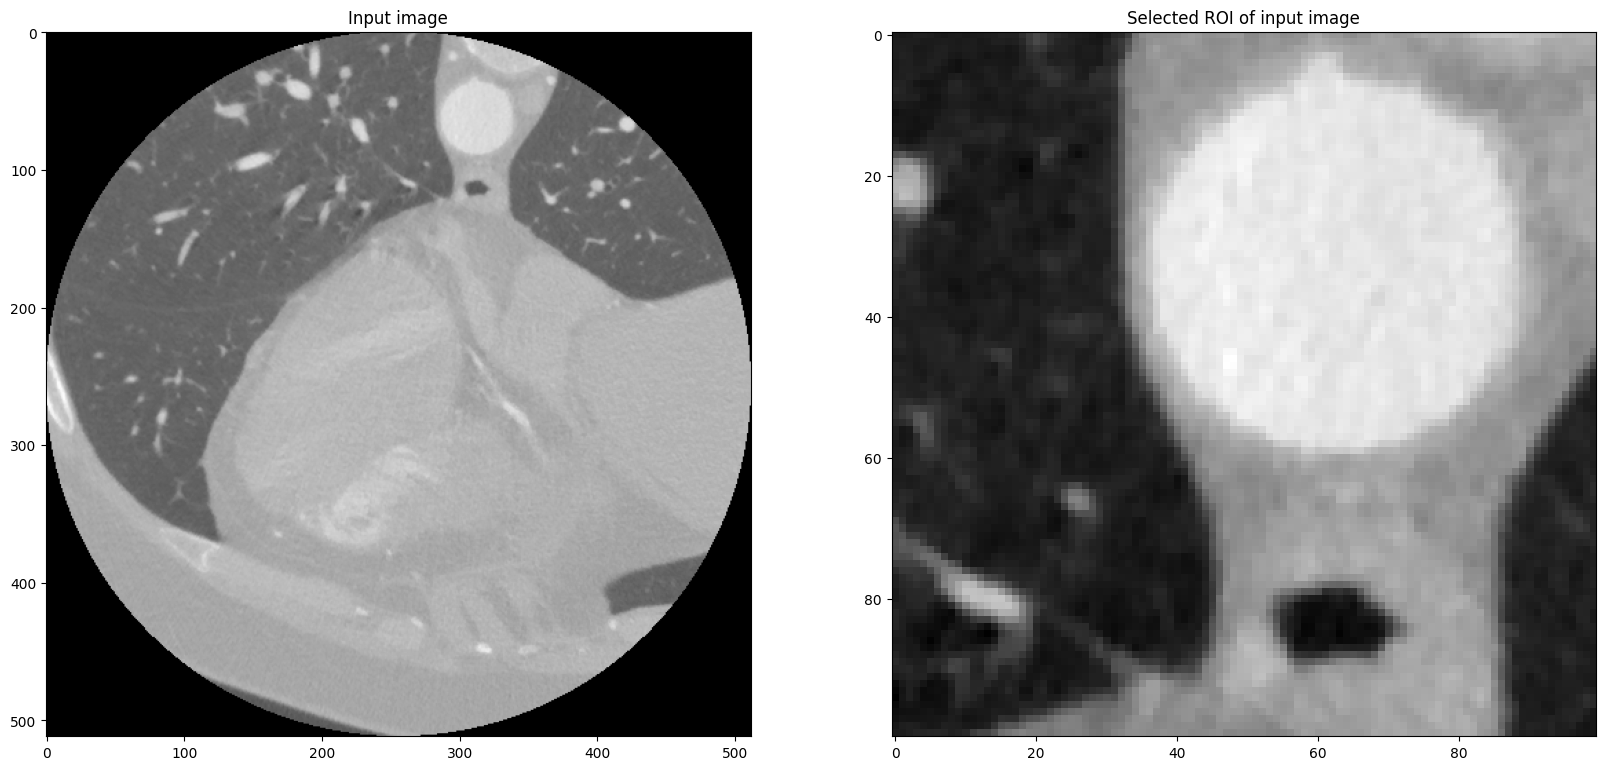

In [32]:
fig, axs = plt.subplots(1, 2, figsize = (20,20))
axs[0].imshow(image); axs[0].set_title("Input image")
axs[1].imshow(image[30:130, 250:350]); axs[1].set_title("Selected ROI of input image");

In [33]:
def get_denoised_image(reference_image, input_random_image, model, epochs, plot):

    nxd = reference_image.shape[0]
    device = torch.device('cpu')

    image_torch = np_to_torch(reference_image).to(device)

    cnn = model.to(device)

    input_image = input_random_image.to(device)

    optimiser = torch.optim.Adam(cnn.parameters(),lr=1e-4)
    train_loss = list()
    nrmse_list = list()
    for ep in range(epochs):
        optimiser.zero_grad()
        output_image = cnn(input_image)

        loss = nrmse(output_image,image_torch )

        train_loss.append(loss.item())
        loss.backward()
        optimiser.step()
        if ep % 2 == 0 and plot == True:
            fig, axs = plt.subplots(2, 2, figsize = (20,20))
            axs[0,0].set_title("Input image")
            axs[0,0].imshow(input_image)
            axs[0,1].set_title("Denoised image")
            axs[0,1].imshow(torch_to_np(output_image))
            axs[1,0].set_title(f"Loss epoch:{ep}")
            axs[1,0].plot(train_loss)
            axs[1,0].grid()
            axs[1,1].set_title("Orginal image")
            axs[1,1].imshow(image_torch)
            clear_output(wait=True); plt.pause(0.001)
    output_image_np = torch_to_np(output_image)    
    save_array(output_image_np, f"denoised_image_{epochs}.npy")
    save_array(reference_image, f"orginal_image_{epochs}.npy")
    return output_image_np

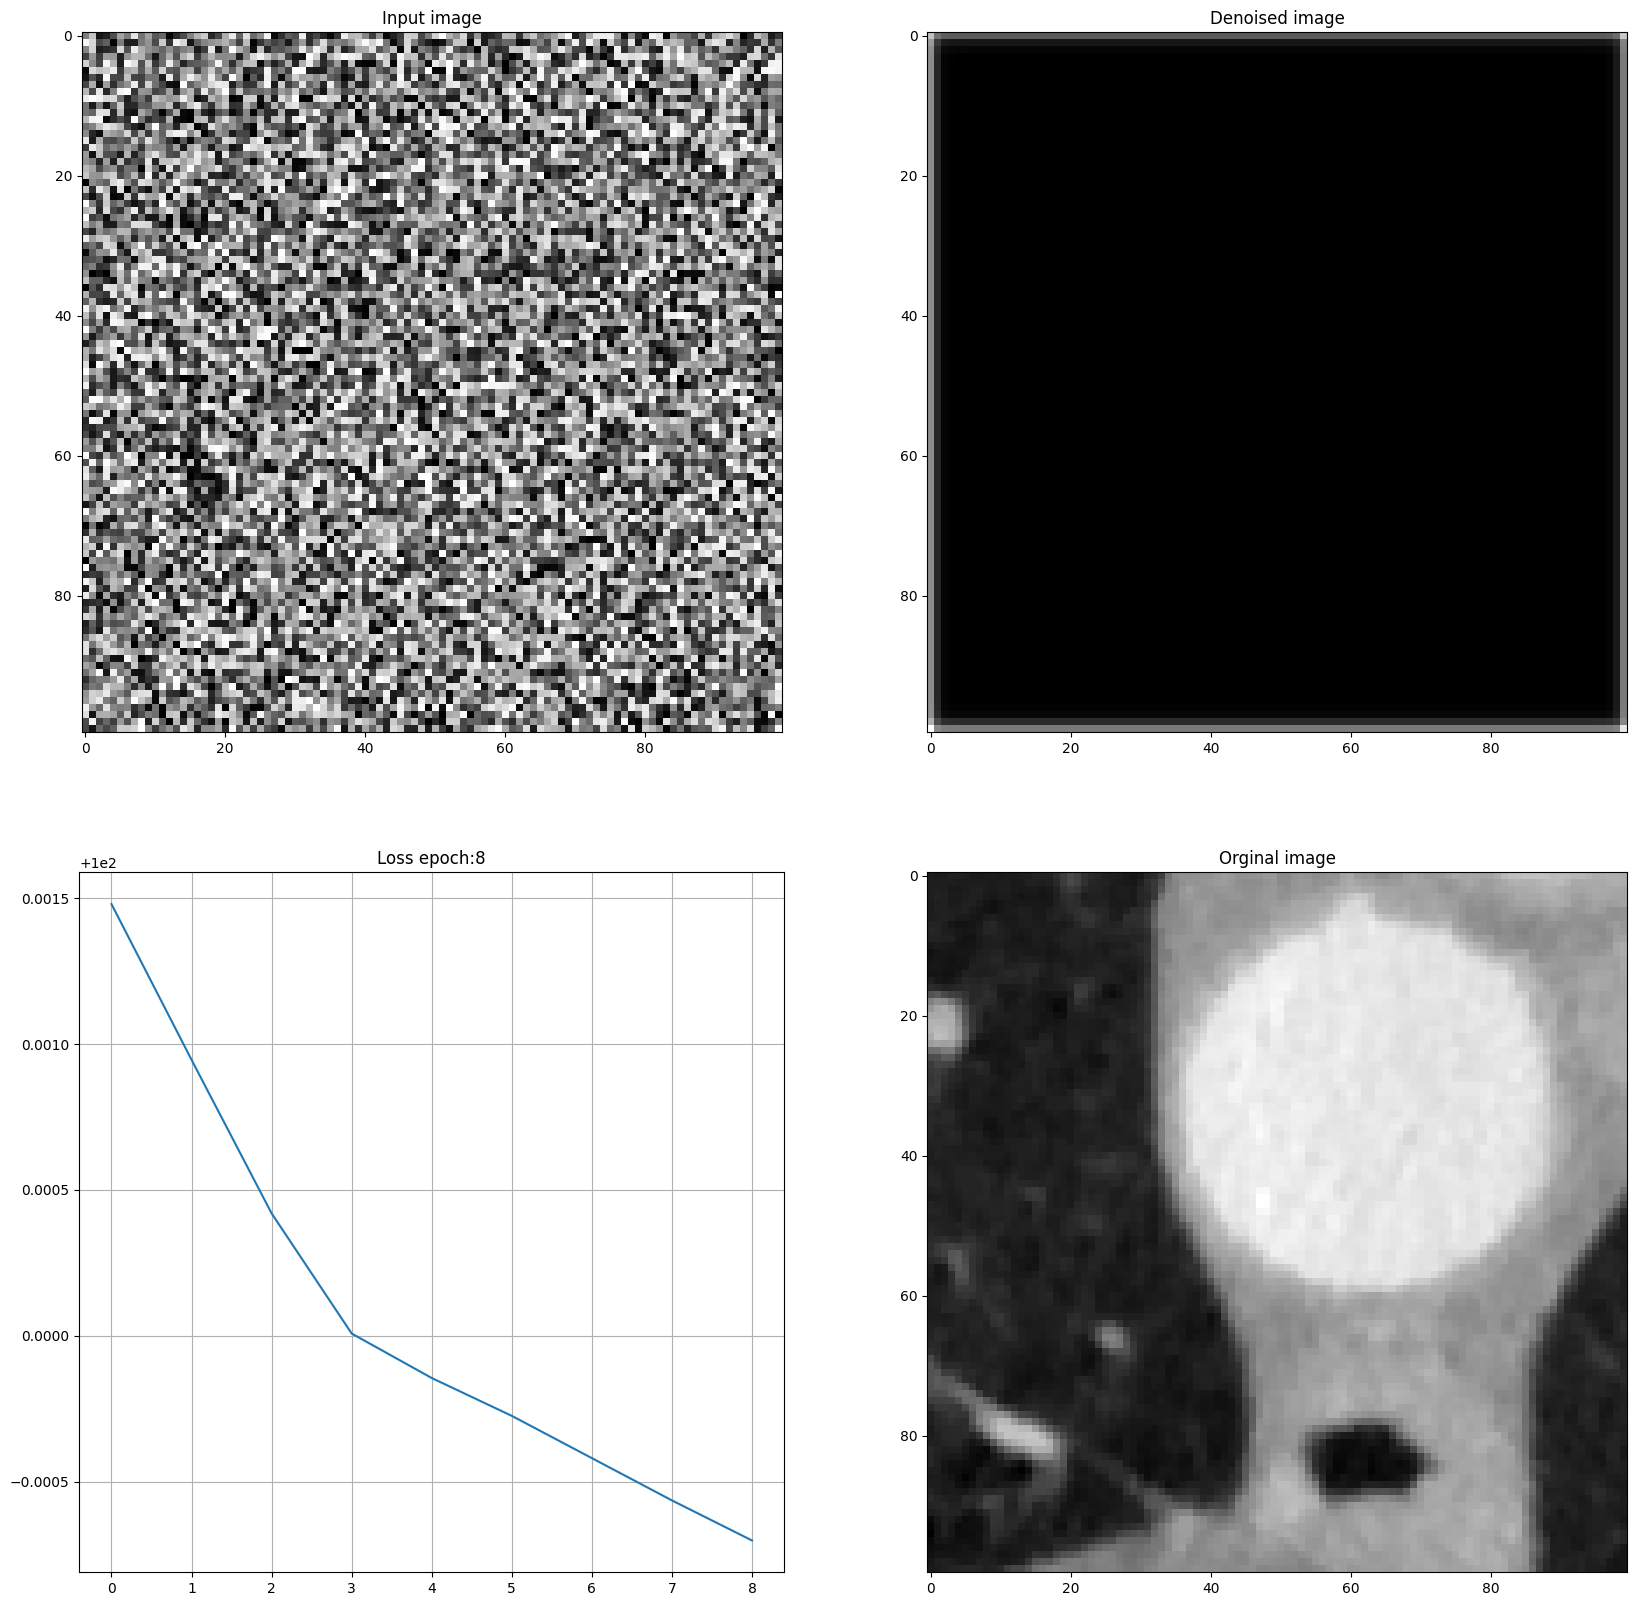

In [34]:
torch.manual_seed(0)
reference_image = image[30:130, 250:350]
input_random_image = torch.rand(100,100)
model = CNN_configurable(16,100,3)
epochs = 10
output_image = get_denoised_image(reference_image, input_random_image, model, epochs, True)

In [35]:
output_image = load_array("denoised_image_10000.npy")

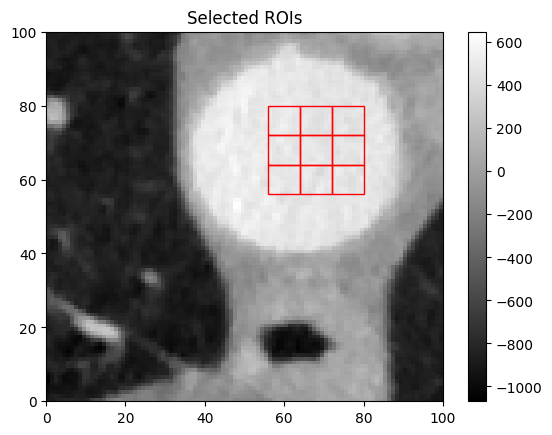

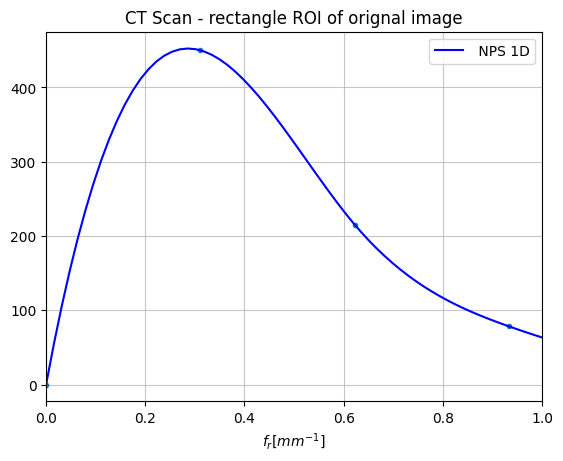

In [36]:
ROI_array_rectangle =select_ROI_array_ractangle(image=np.flipud(image[30:130, 250:350]), y0=60, x0=60, size=8, num=9, plot=True)
plt.show()


NPS_2D_rectangle = calculate_NPS_2D(ROI_array_rectangle, pixel_size_x, pixel_size_y)
rad_1, intensity_1 = calculate_NPS_1D_test(NPS_2D_rectangle,pixel_size_x)
make_plot(rad_1, intensity_1, title="CT Scan - rectangle ROI of orignal image", legend = " NPS 1D", min_x=0, max_x =1.0, num=64)

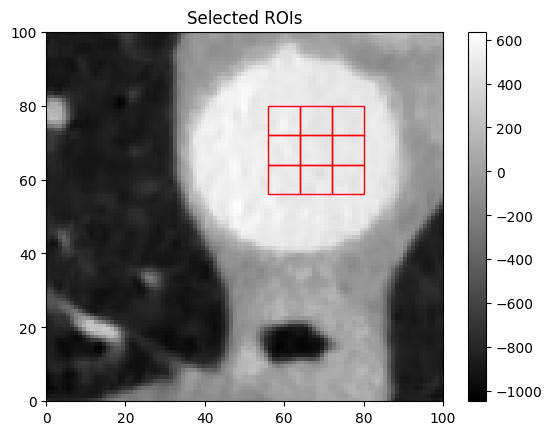

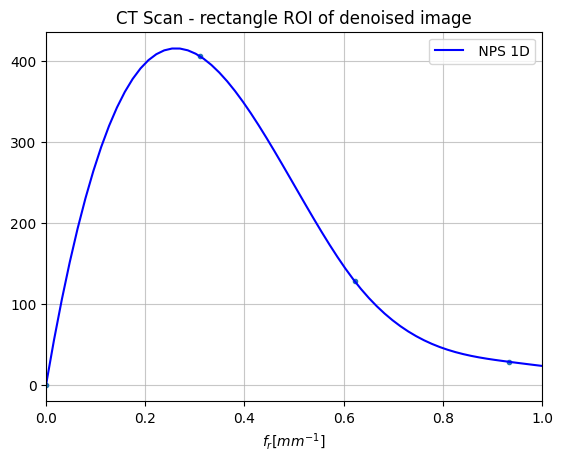

In [37]:
ROI_array_rectangle =select_ROI_array_ractangle(image=np.flipud(output_image), y0=60, x0=60, size=8, num=9, plot=True)
plt.show()

NPS_2D_rectangle = calculate_NPS_2D(ROI_array_rectangle, pixel_size_x, pixel_size_y)
rad_2, intensity_2 = calculate_NPS_1D_test(NPS_2D_rectangle,pixel_size_x)
make_plot(rad_2, intensity_2, title="CT Scan - rectangle ROI of denoised image", legend = " NPS 1D", min_x=0, max_x =1.0, num=64)

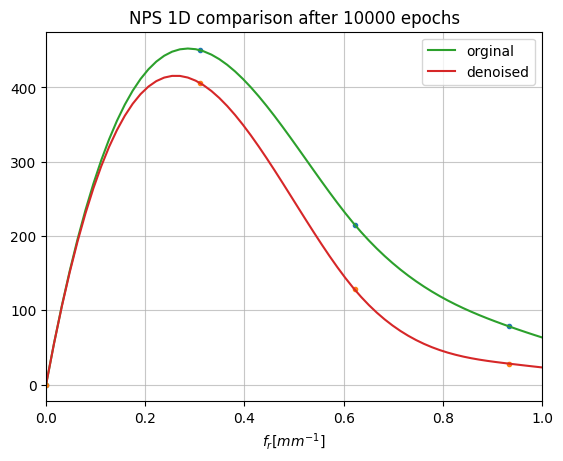

In [38]:
make_two_plots(rad_1, intensity_1, rad_2, intensity_2, "NPS 1D comparison after 10000 epochs", "orginal", "denoised", min_x=0, max_x=1.0, num=64)